## Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Load dataset con features
df = pd.read_csv('../data/processed/matches_with_features.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Check missing values in features
feature_cols = ['home_elo_before', 'away_elo_before', 'elo_diff',
                'home_form_5', 'away_form_5', 'form_diff',
                'home_goals_avg_5', 'away_goals_avg_5',
                'home_conceded_avg_5', 'away_conceded_avg_5',
                'home_shots_avg_5', 'away_shots_avg_5']

print("\nMissing values per feature:")
print(df[feature_cols].isnull().sum())

# Drop rows con missing (primi match di ogni squadra)
df_clean = df.dropna(subset=feature_cols)
print(f"\nAfter dropping NaN: {len(df_clean)} matches ({len(df) - len(df_clean)} removed)")

Dataset shape: (1580, 34)
Date range: 2021-08-21 00:00:00 to 2025-10-05 00:00:00

Missing values per feature:
home_elo_before         0
away_elo_before         0
elo_diff                0
home_form_5            14
away_form_5            13
form_diff              17
home_goals_avg_5        0
away_goals_avg_5        0
home_conceded_avg_5     0
away_conceded_avg_5     0
home_shots_avg_5        0
away_shots_avg_5        0
dtype: int64

After dropping NaN: 1563 matches (17 removed)


## Train/Test

In [3]:
# CRITICAL: Split TEMPORALE, non random!
# Train: fino a fine stagione 2023-24
# Test: stagione 2024-25

train_cutoff = '2024-06-30'  # Fine stagione 23-24
df_clean = df_clean.sort_values('date')

train_df = df_clean[df_clean['date'] <= train_cutoff]
test_df = df_clean[df_clean['date'] > train_cutoff]

print("="*60)
print("TRAIN/TEST SPLIT")
print("="*60)
print(f"Train set: {len(train_df)} matches ({train_df['date'].min().date()} to {train_df['date'].max().date()})")
print(f"Test set:  {len(test_df)} matches ({test_df['date'].min().date()} to {test_df['date'].max().date()})")
print(f"\nTrain seasons: {train_df['season'].unique()}")
print(f"Test season: {test_df['season'].unique()}")

# Prepare X and y
X_train = train_df[feature_cols]
y_train_home = train_df['home_goals']
y_train_away = train_df['away_goals']

X_test = test_df[feature_cols]
y_test_home = test_df['home_goals']
y_test_away = test_df['away_goals']
y_test_result = test_df['result']

print(f"\nFeatures: {len(feature_cols)}")
print(X_train.columns.tolist())

TRAIN/TEST SPLIT
Train set: 1126 matches (2021-08-27 to 2024-06-02)
Test set:  437 matches (2024-08-17 to 2025-10-05)

Train seasons: ['2021-22' '2022-23' '2023-24']
Test season: ['2024-25' '2025-26']

Features: 12
['home_elo_before', 'away_elo_before', 'elo_diff', 'home_form_5', 'away_form_5', 'form_diff', 'home_goals_avg_5', 'away_goals_avg_5', 'home_conceded_avg_5', 'away_conceded_avg_5', 'home_shots_avg_5', 'away_shots_avg_5']


## Baseline

In [6]:
# Baseline 1: Predici sempre la media
baseline_home = y_train_home.mean()
baseline_away = y_train_away.mean()

pred_baseline_home = np.full(len(y_test_home), baseline_home)
pred_baseline_away = np.full(len(y_test_away), baseline_away)

mae_baseline_home = mean_absolute_error(y_test_home, pred_baseline_home)
mae_baseline_away = mean_absolute_error(y_test_away, pred_baseline_away)

print("="*60)
print("BASELINE MODEL (Always predict mean)")
print("="*60)
print(f"Training mean home goals: {baseline_home:.2f}")
print(f"Training mean away goals: {baseline_away:.2f}")
print(f"\nTest MAE home goals: {mae_baseline_home:.3f}")
print(f"Test MAE away goals: {mae_baseline_away:.3f}")
print(f"Combined MAE: {(mae_baseline_home + mae_baseline_away) / 2:.3f}")

# Converti in 1X2 per accuracy
def goals_to_result(home_pred, away_pred):
    """Converti goals predetti in H/D/A"""
    if home_pred > away_pred:
        return 'H'
    elif away_pred > home_pred:
        return 'A'
    else:
        return 'D'

baseline_results = [goals_to_result(baseline_home, baseline_away) for _ in range(len(y_test_result))]
baseline_accuracy = accuracy_score(y_test_result, baseline_results)

print(f"\n1X2 Accuracy: {baseline_accuracy:.1%}")
print("\nThis is what we need to BEAT!")

BASELINE MODEL (Always predict mean)
Training mean home goals: 1.44
Training mean away goals: 1.22

Test MAE home goals: 0.972
Test MAE away goals: 0.868
Combined MAE: 0.920

1X2 Accuracy: 39.6%

This is what we need to BEAT!


## Xg Boost

In [ ]:
from xgboost import XGBRegressor

# Train 2 modelli separati: home goals e away goals
print("Training XGBoost models...")

# Model per home goals
model_home = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    objective='reg:squarederror'
)

model_home.fit(X_train, y_train_home)

# Model per away goals
model_away = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    objective='reg:squarederror'
)

model_away.fit(X_train, y_train_away)

print("✅ Models trained!")

# Predictions
pred_home = model_home.predict(X_test)
pred_away = model_away.predict(X_test)

# Clip negative predictions (non esistono goals negativi!)
pred_home = np.maximum(pred_home, 0)
pred_away = np.maximum(pred_away, 0)

# Metrics
mae_home = mean_absolute_error(y_test_home, pred_home)
mae_away = mean_absolute_error(y_test_away, pred_away)

print("\n" + "="*60)
print("XGBOOST MODEL PERFORMANCE")
print("="*60)
print(f"Test MAE home goals: {mae_home:.3f} (baseline: {mae_baseline_home:.3f})")
print(f"Test MAE away goals: {mae_away:.3f} (baseline: {mae_baseline_away:.3f})")
print(f"Combined MAE: {(mae_home + mae_away) / 2:.3f} (baseline: {(mae_baseline_home + mae_baseline_away) / 2:.3f})")

# 1X2 accuracy
pred_results = [goals_to_result(h, a) for h, a in zip(pred_home, pred_away)]
xgb_accuracy = accuracy_score(y_test_result, pred_results)

print(f"\n1X2 Accuracy: {xgb_accuracy:.1%} (baseline: {baseline_accuracy:.1%})")

improvement = xgb_accuracy - baseline_accuracy
print(f"Improvement: {improvement:+.1%}")

if improvement > 0:
    print("\n🎉 MODEL BEATS BASELINE!")
else:
    print("\n⚠️ Model NOT better than baseline (need tuning)")

Training XGBoost models...
✅ Models trained!

XGBOOST MODEL PERFORMANCE
Test MAE home goals: 0.911 (baseline: 0.972)
Test MAE away goals: 0.854 (baseline: 0.868)
Combined MAE: 0.882 (baseline: 0.920)

1X2 Accuracy: 51.9% (baseline: 39.6%)
Improvement: +12.4%

🎉 MODEL BEATS BASELINE!


## Feature Importance

FEATURE IMPORTANCE
            feature  importance_avg
           elo_diff        0.189971
   away_shots_avg_5        0.085864
home_conceded_avg_5        0.084012
   home_shots_avg_5        0.082697
          form_diff        0.080927
    away_elo_before        0.075487
   home_goals_avg_5        0.070404
   away_goals_avg_5        0.070199
        home_form_5        0.069262
        away_form_5        0.068812
    home_elo_before        0.061330
away_conceded_avg_5        0.061036


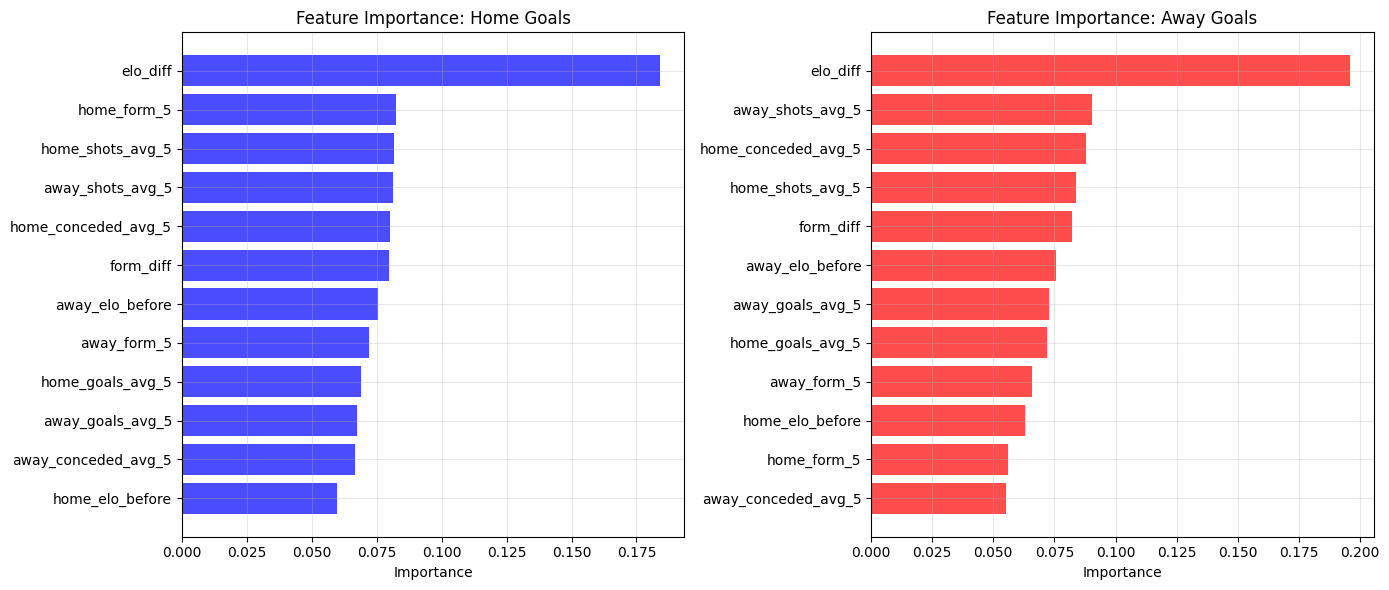

In [9]:
# Feature importance da entrambi i modelli
importance_home = pd.DataFrame({
    'feature': feature_cols,
    'importance_home': model_home.feature_importances_
})

importance_away = pd.DataFrame({
    'feature': feature_cols,
    'importance_away': model_away.feature_importances_
})

importance = importance_home.merge(importance_away, on='feature')
importance['importance_avg'] = (importance['importance_home'] + importance['importance_away']) / 2
importance = importance.sort_values('importance_avg', ascending=False)

print("="*60)
print("FEATURE IMPORTANCE")
print("="*60)
print(importance[['feature', 'importance_avg']].to_string(index=False))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Home goals
importance_home_sorted = importance.sort_values('importance_home', ascending=True)
axes[0].barh(importance_home_sorted['feature'], importance_home_sorted['importance_home'], color='blue', alpha=0.7)
axes[0].set_xlabel('Importance')
axes[0].set_title('Feature Importance: Home Goals')
axes[0].grid(alpha=0.3)

# Away goals
importance_away_sorted = importance.sort_values('importance_away', ascending=True)
axes[1].barh(importance_away_sorted['feature'], importance_away_sorted['importance_away'], color='red', alpha=0.7)
axes[1].set_xlabel('Importance')
axes[1].set_title('Feature Importance: Away Goals')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()